# Ethereum Time Series Prediction with Recurrent Neural Networks

#### Import necessary library needed for the model training

In [1]:
from google.colab import drive
drive.mount('/content/Drive')
import sys
sys.path.append('/content/Drive/Shareddrives/Thesis/Trading') # Updating our path to import drom drive

Mounted at /content/Drive


In [2]:
!pip install keras-tuner -q

     |████████████████████████████████| 97 kB 4.4 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import importlib

from math import sqrt
from numpy import concatenate
from datetime import datetime

# Sklearn Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Keras Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from keras_tuner import BayesianOptimization
from tensorflow.keras import layers
import keras.backend as K
from keras.regularizers import l2

import ThesisUtils as tu
%matplotlib inline

#### Importing the data and reshaping it into 3D input that is required for RNNs

In [4]:
importlib.reload(tu)
# Reading in the data
output_num = ""
X_train = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_X_train{}.csv".format(output_num)).values
X_test = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_X_test{}.csv".format(output_num)).values
y_train = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_y_train{}.csv".format(output_num)).values.ravel()
y_test = pd.read_csv("/content/Drive/Shareddrives/Thesis/Trading/Datasets/stacked_y_test{}.csv".format(output_num)).values.ravel()

classification = False
if classification:
  y_train = np.where(y_train > 0,1,0)
  y_test = np.where(y_test > 0,1,0)

plus_one = False
if plus_one:
  y_train += 1
  y_test +=1

mult = False
if mult:
  y_train *= 100
  y_test *= 100


#keep = [0,8,9,10,11] # what cols to keep, drop the lagged values except for lag1
keep = [0,5,6] # what cols to keep, drop the lagged value
X_train = X_train[:,keep]
X_test = X_test[:,keep]

test_size = 1/3
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = test_size, shuffle=False)

NUM_LAGS = 7
X_valid = X_valid[NUM_LAGS:,:]
y_valid = y_valid[NUM_LAGS:]
X_test = X_test[NUM_LAGS:,:]
y_test = y_test[NUM_LAGS:]

# PCA
use_pca = True
if True:
  pca = PCA()
  pca.fit(X_train)
  X_train = pca.transform(X_train)
  X_test = pca.transform(X_test)
  X_valid = pca.transform(X_valid)

use_scaling = True
if use_scaling:
  # Scaling the data to the range [0,1]
  scaler_X = MinMaxScaler(feature_range=(0, 1))
  X_train = X_train.astype('float64')
  X_train = scaler_X.fit_transform(X_train)
  X_test = scaler_X.transform(X_test)
  X_valid = scaler_X.transform(X_valid)

N_STEPS = 7
X_train, y_train = tu.split_sequences(X_train,y_train,n_steps = N_STEPS)
X_valid, y_valid = tu.split_sequences(X_valid,y_valid,n_steps = N_STEPS)
X_test, y_test = tu.split_sequences(X_test,y_test,n_steps = N_STEPS)



In [5]:
X_train.shape

(29874, 7, 3)

#### Defining the custom loss function to be used 

In [6]:
def betsizer(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  squared = K.square(y_true*y_pred - 1)
  return K.mean(squared) 

def rmse(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

#### Defining the callbacks to be used

In [7]:
#early_stopping = EarlyStopping(monitor='val_loss', mode = 'min',min_delta=0.00001 ,patience = 300, restore_best_weights=True, verbose = True)
early_stopping = EarlyStopping(monitor='loss', mode = 'min',min_delta=0.00001 ,patience = 1000, restore_best_weights=True, verbose = True)

#### Hyperparameter Tuning

In [ ]:

#reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor = 0.2, patience = 10, min_lr = 0.000001, verbose = 1)

In [9]:
def build_model(hp):
  model = Sequential()
  model.add(
      LSTM(
          hp.Int("units_1", min_value = 4, max_value = 4*30, step = 4),
           return_sequences = False,
           
           input_shape=(X_train.shape[1], X_train.shape[2])))

  #model.add(Dropout(rate = hp.Float('dropout_1', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.01)))
  #model.add(LSTM(hp.Int("units_2", min_value = 32, max_value = 192, step = 32)))
  model.add(Dense(1, activation = "tanh"))
  model.compile(loss=betsizer, optimizer= Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-1,sampling = "LOG", default = 1e-3)))
  return model


In [10]:
class MyTuner(BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 16, 16*8, step=16)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 20, 200,step = 10)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same arguments as the BayesianOptimization Tuner.
tuner = MyTuner(
    build_model,
    objective="val_loss",
    max_trials= 50,
    executions_per_trial=2,
    overwrite = True)


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', patience = 20, restore_best_weights=True, verbose = True)
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), verbose=2, shuffle=False, callbacks = [early_stopping]) # Don't batch_size here, let the Tuner tune them.

Trial 50 Complete [00h 00m 40s]
val_loss: 0.9999778568744659

Best val_loss So Far: 0.9999776184558868
Total elapsed time: 01h 43m 54s
INFO:tensorflow:Oracle triggered exit


In [12]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 68)                19584     
_________________________________________________________________
dense (Dense)                (None, 1)                 69        
Total params: 19,653
Trainable params: 19,653
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train, epochs = best_hp.get("epochs"), validation_data=(X_test, y_test),batch_size= best_hp.get("batch_size"), verbose=2, shuffle=False)

Epoch 1/100
467/467 - 3s - loss: 1.0000 - val_loss: 1.0000
Epoch 2/100
467/467 - 1s - loss: 1.0000 - val_loss: 1.0000
Epoch 3/100
467/467 - 1s - loss: 1.0000 - val_loss: 1.0000
Epoch 4/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9999
Epoch 5/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9999
Epoch 6/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9999
Epoch 7/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9999
Epoch 8/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9999
Epoch 9/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9999
Epoch 10/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9998
Epoch 11/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9998
Epoch 12/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9998
Epoch 13/100
467/467 - 1s - loss: 1.0000 - val_loss: 0.9998
Epoch 14/100
467/467 - 1s - loss: 0.9999 - val_loss: 0.9998
Epoch 15/100
467/467 - 1s - loss: 0.9999 - val_loss: 0.9998
Epoch 16/100
467/467 - 1s - loss: 0.9999 - val_loss: 0.9997
Epoch 17/100
467/467 - 1s - loss: 0.9999 - val_lo

In [15]:
print(best_hp.get("batch_size"))
print(best_hp.get("learning_rate"))

64
1.205042823825181e-05


#### Predicting

In [16]:
ypred_test = model.predict(X_test).ravel()
ypred_train = model.predict(X_train).ravel()

if classification:
  ypred_train = np.sign(ypred_train - 0.5)
  ypred_test = np.sign(ypred_test - 0.5)

if plus_one:
  ypred_train = 1-ypred_train
  ypred_test = 1-ypred_test
  y_train -= 1
  y_test -= 1

if mult:
  #ypred_train = ypred_train/100
  #ypred_test = ypred_test/100
  y_train = y_train/100
  y_test = y_test/100


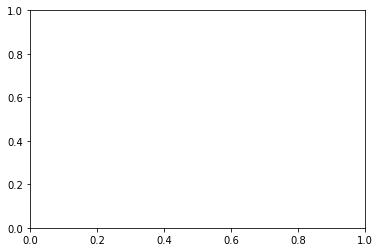

In [17]:
sns.kdeplot(ypred_train[abs(ypred_train) < 0.9])

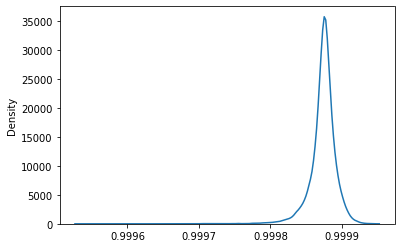

In [18]:
sns.kdeplot(ypred_train)

#### Plot line graph to show amount loss according the the epoch

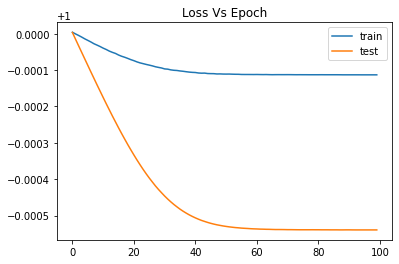

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss Vs Epoch")
plt.legend()
plt.show()

#### Investigating the train model performance 

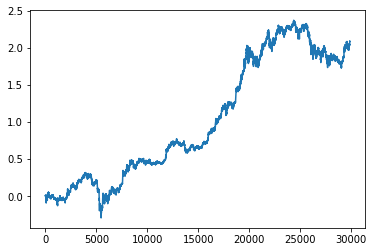

In [20]:
plt.plot(np.cumsum(np.sign(ypred_train)*y_train))


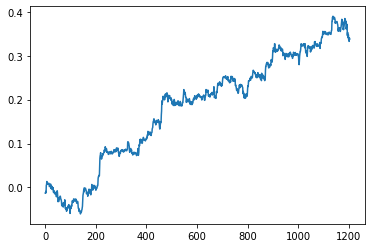

In [21]:
plt.plot(np.cumsum(ypred_test*y_test))

### Writing outputs to CSV files

In [22]:

loss = pd.DataFrame()
loss["train"] = history.history['loss']
loss['test'] = history.history['val_loss']
loss.to_csv("/content/Drive/Shareddrives/Thesis/Trading/loss_rnn.csv", index = False)

test_output = pd.DataFrame()
test_output['y_test'] = y_test.ravel()
test_output['ypred_test'] = ypred_test.ravel()
test_output.to_csv("/content/Drive/Shareddrives/Thesis/Trading/output_test_rnn.csv", index = False)

train_output = pd.DataFrame()
train_output['y_train'] = y_train.ravel()
train_output['ypred_train'] = ypred_train.ravel()
train_output.to_csv("/content/Drive/Shareddrives/Thesis/Trading/output_train_rnn.csv", index = False)